# Neural Style Transfer 


## Importing Libraries

In [3]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

## Load & preprocess images

In [6]:
def load_img(path_to_img, max_dim=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if tensor.ndim > 3:
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

## Define content and style layers

In [11]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Load VGG19 

In [19]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

## Gram Matrix for style 

In [21]:
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    shape = tf.shape(tensor)
    num_locations = tf.cast(shape[1]*shape[2], tf.float32)
    return result / num_locations

## Style and content extractor model

In [24]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed)
        style_outputs, content_outputs = (outputs[:num_style_layers],
                                          outputs[num_style_layers:])
        style_outputs = [gram_matrix(style) for style in style_outputs]

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        return {'style': style_dict, 'content': content_dict}

## Loss calculation 

In [27]:

def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-2, content_weight=1e4):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs
    ])
    content_loss *= content_weight / num_content_layers

    return style_loss + content_loss

## Optimization setup 

In [30]:

@tf.function()
def train_step(image, extractor, style_targets, content_targets, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

## Load images

In [33]:
content_path = 'my.jpg'
style_path = 'images-6.jpg'
content_image = load_img(content_path)
style_image = load_img(style_path)

## Display Content and Style Images 

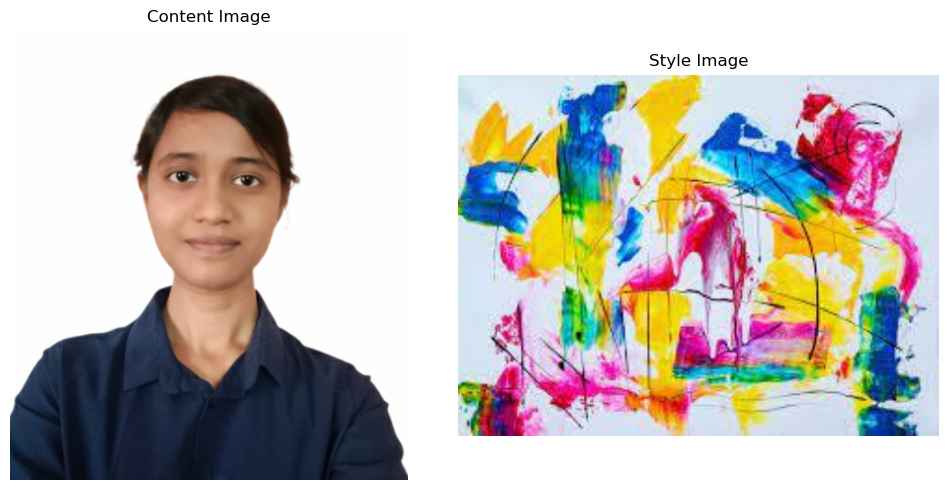

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_image(img_tensor, title="Image"):
    if len(img_tensor.shape) == 4:
        img_tensor = img_tensor[0]  # batch dimension is removed

    img_tensor = tf.squeeze(img_tensor)

    # Normalize between 0 and 1
    img_min = tf.reduce_min(img_tensor)
    img_max = tf.reduce_max(img_tensor)
    img_tensor = (img_tensor - img_min) / (img_max - img_min + 1e-5)

    plt.imshow(img_tensor.numpy())
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
show_image(content_image, "Content Image")

plt.subplot(1, 2, 2)
show_image(style_image, "Style Image")

plt.tight_layout()
plt.show()


## Extract features 

In [45]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

## Initialize generated image

In [50]:
generated_image = tf.Variable(content_image)

## Training loop

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
epochs = 10
steps_per_epoch = 100

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(generated_image, extractor, style_targets, content_targets, optimizer)
    print(f"Epoch {epoch+1} completed.")

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.


## Save final image

In [57]:
final_image = tensor_to_image(generated_image)
final_image.save("customized_image.jpg")

## Visualize Final Stylized Image

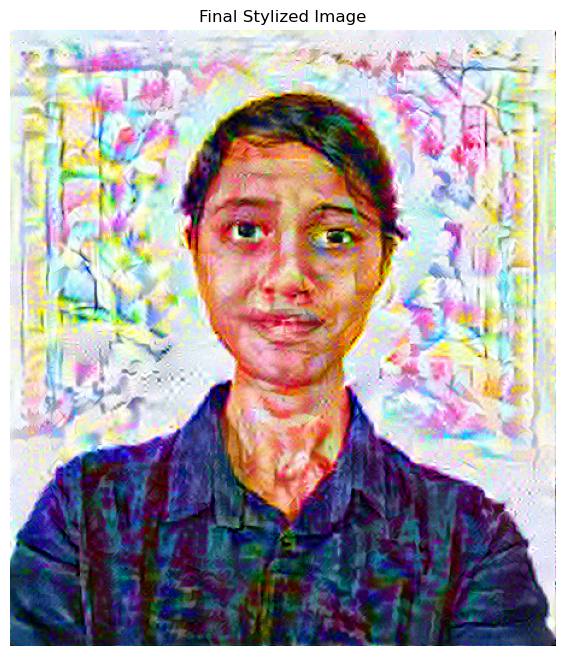

In [61]:
final_stylized_image = tensor_to_image(generated_image)
plt.figure(figsize=(8, 8))
plt.imshow(final_stylized_image)
plt.title("Final Stylized Image")
plt.axis('off')
plt.show()
